In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# ===========================================================================
# Calculation of geometric properties of boundary element segments
# ===========================================================================
def geometry(x_list,y_list,seg_list):
    Ns = np.sum(seg_list) # total no. of segments
    Np = Ns+1 # total no. of segment end-points
    
    lb = np.sqrt((x_list[1:]-x_list[:-1])**2 + (y_list[1:]-y_list[:-1])**2)

    # total no. of segments at the beginning of each boundary element
    seg_num = np.zeros(seg_list.size)
    for i in range(1,seg_list.size):
        seg_num[i] = seg_num[i-1] + seg_list[i-1]

    x, y = [np.zeros(Np) for i in range(2)]
    x[0] = x[-1] = x_list[0]; y[0] = y[-1] = y_list[0]
    for i in range(seg_list.size):
        x[int(seg_num[i]):int(seg_num[i]+seg_list[i]+1)] = np.linspace(x_list[i],x_list[i+1],seg_list[i]+1)
        y[int(seg_num[i]):int(seg_num[i]+seg_list[i]+1)] = np.linspace(y_list[i],y_list[i+1],seg_list[i]+1)

    # mid-pt of segments
    xm = 0.5*(x[1:] + x[:-1])
    ym = 0.5*(y[1:] + y[:-1])

    # list of mid-pts by boundary element index
    xms, yms = [[0]*seg_list.size for i in range(2)] # sequence with 1 element for each segment 
    for i in range(seg_list.size):
        xms[i] = np.array(xm[int(seg_num[i]):int(seg_num[i]+seg_list[i])])
        yms[i] = np.array(ym[int(seg_num[i]):int(seg_num[i]+seg_list[i])])

    # length of segments
    l = np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)

    # normal vectors
    ny = (x[:-1] - x[1:])/l
    nx = (y[1:] - y[:-1])/l

    return x, y, xm, ym, xms, yms, nx, ny, l, Ns, seg_num, lb

In [4]:
# ===========================================================================
# Setting boundary conditions for each segement of boundary element
# ===========================================================================
def setBC(bct,bcv,seg_list,seg_num):
    BCT, BCV = [np.zeros(Ns) for i in range(2)]
    for i in range(seg_list.size):
        BCT[int(seg_num[i]):int(seg_num[i]+seg_list[i])] = bct[i]
        BCV[int(seg_num[i]):int(seg_num[i]+seg_list[i])] = bcv[i]
        
    return BCT, BCV

In [5]:
# ===========================================================================
# Calculate integral coefficients F1 & F2 for a given array of points (x0,y0)
# ===========================================================================
def F1F2(x0,y0,x,y,l,nx,ny):    
    k = int(Ns) # no. of segments
    s = x0.size # no. of points

    A, B, E, F1, F2 = [np.zeros((k,s)) for i in range(5)]
    k = np.arange(k)
    s = np.arange(s)    
    K, S = np.meshgrid(k,s)
    
    A[K,:] = np.square(l[K]).T
    B[K,S] = 2*l[K]*(-(x[K]-x0[S])*ny[K] + (y[K]-y0[S])*nx[K])
    E[K,S] = (x[K]-x0[S])**2 + (y[K]-y0[S])**2

    M = 4*A*E - B**2
    D = 0.5*B/A
    
    zero = 1e-10 # a very small number to take care of floating point errors
    # Jth point (x0[J],y0[J]) intersects the (extended) Ith line segment
    I,J = np.where(M<zero)
    # jth point (x0[j],y0[j]) does not intersect (extended) ith line segment
    i,j = np.where(M>zero)

    # for M = 0 (lim D->0 D*ln(D)=0 )
    # since the log function cannot handle log(0), 'zeros' have been added to log(D) -> log(D+zero)
    F1[I,J] = 0.5*l[I]*(np.log(l[I]) \
                          + (1 + D[I,J])*np.log(np.abs(1 + D[I,J]) + zero) \
                          - D[I,J]*np.log(np.abs(D[I,J] + zero)) - 1)/np.pi
    # for M > 0
    H = np.arctan((2*A[i,j]+B[i,j])/np.sqrt(M[i,j])) - np.arctan(B[i,j]/np.sqrt(M[i,j]))
    F1[i,j] = 0.25*l[i]*(2*(np.log(l[i]) - 1) \
                           - D[i,j]*np.log(np.abs(E[i,j]/A[i,j])) \
                           + (1 + D[i,j])*np.log(np.abs(1 + 2*D[i,j] + E[i,j]/A[i,j])) \
                           + H*np.sqrt(M[i,j])/A[i,j])/np.pi
    F2[i,j] = l[i]*(nx[i]*(x[i] - x0[j]) + ny[i]*(y[i] - y0[j]))*H/np.sqrt(M[i,j])/np.pi

    return F1.T, F2.T

In [6]:
# ===========================================================================
# Build matrix system from F1 & F2 to find remaining BCs 
# ===========================================================================
def pqBC(F1,F2,BCT,BCV):
    Ns = BCT.size
    F2x = F2 - 0.5*np.eye(Ns)
    a,b = [np.zeros((Ns,Ns)) for i in range(2)]

    # phi is known - d(phi)/dn is unknown
    col_p = np.where(BCT==0)
    a[:,col_p] = -F1[:,col_p]
    b[:,col_p] = -F2x[:,col_p]
    # d(phi)/dn is known - phi is unknown
    col_q = np.where(BCT==1)
    a[:,col_q] = F2x[:,col_q]
    b[:,col_q] = F1[:,col_q]

    BCV2 = np.linalg.solve(a,np.dot(b,BCV))

    p = BCV2.copy()
    q = BCV2.copy()

    p[col_p] = BCV[col_p] # replace with known 'phi's
    q[col_q] = BCV[col_q] # replace with known 'd(phi)/dn's

    return p, q

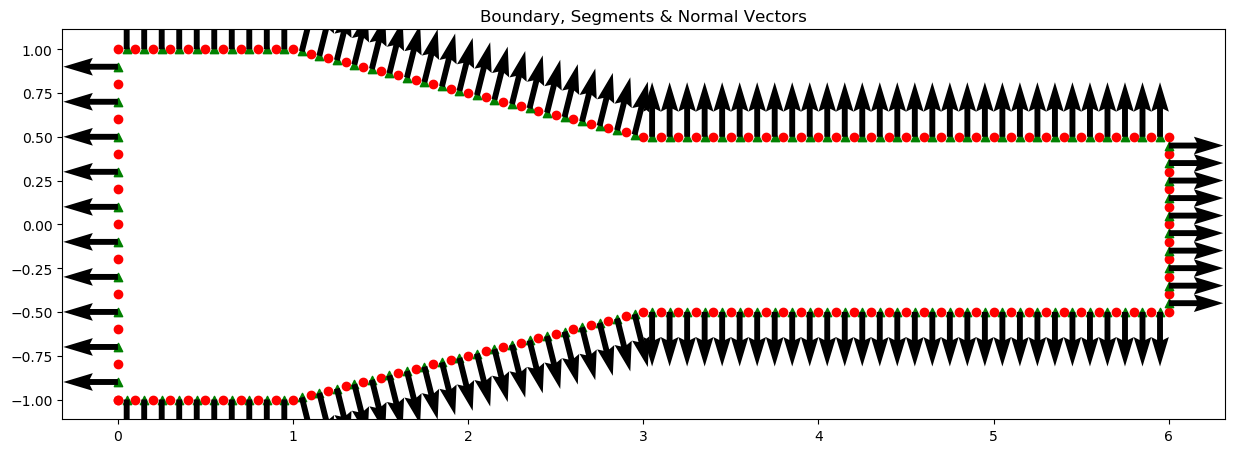

In [13]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# GEOMETRY (must be symmetrical)
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# (x,y)       segment end-points
# (xm, ym)    segment mid-points
# (xms,yms)   segment mid-point grouped by boundary elements
# (nx,ny)     normal vector components centered at (xm,ym)
# l           segment lengths
# Ns          total no. of segments
# seg_num     total no. of segments at the end of each boundary element
# lb          length of boundary element

# Boundary element end-point coordinates (anti-clockwise / last pt = first pt)
x_list = np.array([0.,1.,3.,6.,6.,3.,1.,0.,0.])
y_list = np.array([-1.,-1.,-0.5,-0.5,0.5,0.5,1.,1.,-1.])
# No. of segments for each boundary element
seg_list = np.array([10,20,30,10,30,20,10,10])
# Indices
inlet = 7 # inlet
outlet = 3 # outlet
cb = 1 # beginning of converging area
ce = 2 # end of converging area
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

x, y, xm, ym, xms, yms, nx, ny, l, Ns, seg_num, lb = geometry(x_list,y_list,seg_list)

fig = plt.figure(figsize=(15,7.5),dpi=100)
fig.add_subplot(111,aspect='equal')
plt.scatter(x,y,c=u'r',marker=u'o')
plt.scatter(xm,ym,c=u'g',marker=u'^')
plt.quiver(xm,ym,nx,ny)
plt.title('Boundary, Segments & Normal Vectors')
plt.savefig('diffuser_shape.jpeg')
plt.show()

In [14]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# BOUNDARY CONDITIONS
Q = -1. # volume folow rate
bct = np.ones(seg_list.size) # sequence of boundary condition types: 0->p, 1->q
bcv = np.zeros(seg_list.size) # sequence of boundary condition values
bcv[inlet]  = -Q/lb[inlet]
bcv[outlet] =  Q/lb[outlet]
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

BCT, BCV = setBC(bct,bcv,seg_list,seg_num)

F1, F2 = F1F2(xm,ym,x,y,l,nx,ny) # obtaining F1 & F2 for segment mid-points
p, q = pqBC(F1,F2,BCT,BCV) # solving for additional boundary conditions

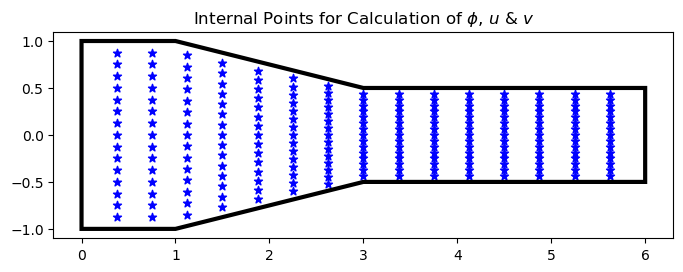

In [15]:
# Generating internal points (excludes boundary)
Nx = 15; Ny = 15;
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

X = np.linspace(x.min(),x.max(),Nx+2)
Y = np.linspace(y.min(),y.max(),Ny+2)
X,Y = np.meshgrid(X,Y)
R = np.abs(y_list).min() / np.abs(y_list).max() # outlet to inlet height ratio
for i in range(Nx+2):
    #  within the converging area
    if (X[0,i] > x_list[cb]) & (X[0,i] < x_list[ce]):
        m = (1 - R)/(x_list[cb] - x_list[ce])
        f = 1 + m*(X[0,i]-x_list[cb])
        Y[:,i] = Y[:,i]*f
    # after the converging area
    if (X[0,i] >= x_list[ce]):
        Y[:,i] = Y[:,i]*R

X = X[1:-1,1:-1].ravel(); Y = Y[1:-1,1:-1].ravel()
fig = plt.figure(figsize=(8,8),dpi=100)
fig.add_subplot(111,aspect='equal')
plt.fill(x,y,fill=False,lw=3)
plt.scatter(X,Y,c=u'b',marker=u'*')
plt.title(r'Internal Points for Calculation of $\phi$, $u$ & $v$')
plt.show()

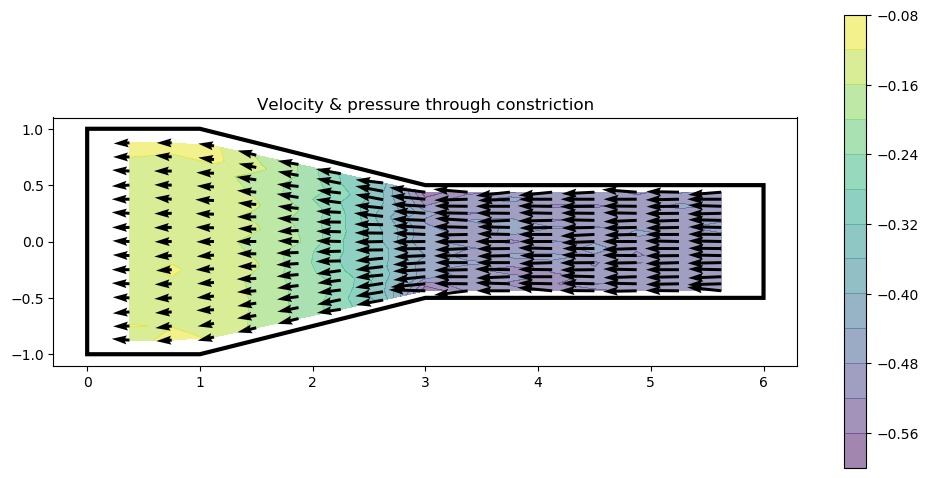

In [16]:
# Calculate velocity (u,v) & pressure P at internal grid points (X,Y)
# ===========================================================================
delta_x = delta_y = 0.05
F1, F2 = F1F2(X+delta_x,Y,x,y,l,nx,ny)
phi_x_plus = (np.dot(F2,p) - np.dot(F1,q)).reshape(Nx,Ny)
F1, F2 = F1F2(X-delta_x,Y,x,y,l,nx,ny)
phi_x_minus = (np.dot(F2,p) - np.dot(F1,q)).reshape(Nx,Ny)
F1, F2 = F1F2(X,Y+delta_y,x,y,l,nx,ny)
phi_y_plus = (np.dot(F2,p) - np.dot(F1,q)).reshape(Nx,Ny)
F1, F2 = F1F2(X,Y-delta_y,x,y,l,nx,ny)
phi_y_minus = (np.dot(F2,p) - np.dot(F1,q)).reshape(Nx,Ny)

# Central difference to determine velocity
u = 0.5*(phi_x_plus - phi_x_minus)/delta_x
v = 0.5*(phi_y_plus - phi_y_minus)/delta_y

# Bernoulli's equation to determine static pressure, P
P = -0.5*(u*u + v*v)

fig = plt.figure(figsize=(12,6), dpi=100)
fig.add_subplot(111,aspect='equal')
plt.fill(x,y,fill=False,lw=3)
plt.contourf(X.reshape(Nx,Ny),Y.reshape(Nx,Ny),P,15,alpha=0.5)
plt.colorbar()
plt.quiver(X,Y,u,v)
plt.title('Velocity & pressure through constriction')
plt.savefig('diffuser_flow.jpeg')
plt.show()